<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Прогнозирование стоимости автомобиля по характеристикам

## Цель проекта
Создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам и поможет быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены)

## Задачи проекта
1. Собрать датасет с данными для обучения модели с помощью парсера;
2. Провести первичную обработку данных. Написать вспомогательные функции;
3. Провести анализ основных переменных, оцените их важность и вклад для модели, сгенерировать новые признаки;
4. Составить отчёт по результатам анализа данных;
5. Обучить несколько различных моделей, сравнить результаты и выбрать лучшую.

Для оценки качества модели используется метрика МАРЕ.

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import sys
import random
import time

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, RandomizedSearchCV, cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor,BaggingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression,f_classif
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
import xgboost as xgb


import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# создадим словарь для хранения показателей моделей
SUBMISSION_DICT = {}

In [5]:
def mape(y_true, y_pred):
    '''Функция для расчета метрики МАРЕ'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

def fill_na_values(column, data):
    '''Функция для заполнения пустых значений в зависимости от типа данных в столбце. 
    Если данные числовые, то пропуск будет заполнен медианой, 
    а остальные будут заполнены рандомно с учетом вероятности.
    '''
    if data.loc[:, column].dtypes == np.dtype('O'):
        values = data[column].value_counts()
        index = data[data[column].isna() == True].index
        new_value = pd.Series(random.choices(
            values.index, values, k=data[column].isna().sum()))
        new_value.index = index
        return data[column].fillna(new_value)
    else:
        return data[column].fillna(data[column].median())
    
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''
    
    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/data.shape[0],1)}%')       
        
def cols_to_drop(data):
    '''Функция для определения столбцов, 
    не влияющих на целевую переменную'''

    # Поиск колонок с большим количеством пропусков, более 90%
    many_null_cols = [
        col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    # Поиск колонок в которых одно из значений встречается > 95%
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(
        dropna=False, normalize=True).values[0] > 0.95]
    # Поиск колонок в которых только одно значение
    one_value_cols = [col for col in data.columns if data[col].nunique() <= 1]

    return list(set(many_null_cols + big_top_value_cols + one_value_cols))

def output_submission(model, name, score, time):
    predict_submission = np.exp(model.predict(X_sub))
    sample_submission['price'] = predict_submission
    
    SUBMISSION_DICT.update({name: f'{score}% with time {time}'})
    
    sample_submission.to_csv(f'submission_{name}_v{VERSION}.csv', index=False)
    print(f'{name} - sample submission')
    display(sample_submission.head(10))

# Setup

In [6]:
VERSION    = 18
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Нами был написан парсер, который собирает данные с сайта auto.ru
C его помощью мы собрали датасет из записей (парсер my_pars.rar можно посмотреть в папке проекта на GitHub).

Однако данный датасет не был использован при обучении модели по нескольким причинам:
1) не удалось обойти блокировку, парсер постоянно банили и удалось собрать очень мало данных;

2) данные, собранные парсером, ухудшали качество модели. Это можно объяснить значительным ростом цен на автомобили с пробегом за последний год. Данный факт подтверждают и статистические данные.

Вот, например, инфографика с сайта аналитического агентства Автостат:

<img src="https://www.autostat.ru/application/includes/blocks/big_photo/images/original/f2a/8c2/366853b406d0c5a564298e0c31.jpg"/>






Можно отметить резкий значительный рост цен на подержанные автомобили в 2021 году. Именно поэтому собранные нами данные не эффективны для обучения, поскольку тестируются на ценах 2020 года.

Обучение модели было проведено на базовом датасете.

In [9]:
pd.set_option('display.max_columns', 32)
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [11]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [13]:
#очевидно, что тестовая и тренировочная выборка сильно отличаются по своей структуре - выясним,каких признаков нет в тестовой выборке, а каких в тренировочной
print('В тестовой выборке нет ', set(train.columns) - set(test.columns))
print('В тренировочной выборке нет ', set(test.columns) - set(train.columns))

В тестовой выборке нет  {'start_date', 'hidden', 'Комплектация', 'price', 'model'}
В тренировочной выборке нет  {'model_name', 'vendor', 'equipment_dict', 'complectation_dict', 'parsing_unixtime', 'model_info', 'priceCurrency', 'image', 'car_url', 'sell_id', 'super_gen'}


In [14]:
# Переименуем названия колонок, которые называются по-разному, но обозначают один и тот же признак
col_rename = {'model': 'model_name','Комплектация': 'complectation_dict'}
train.rename(columns=col_rename, inplace=True)

# Удалим лишние столбцы в train
train.drop(['start_date', 'hidden', 'Таможня','Состояние', 'name'], inplace=True, axis=1)

In [15]:
# удаляем дубликаты train
#train.drop_duplicates(inplace=True,keep='first')

In [16]:
# посмотрим на некоторые признаки поближе, чтобы понять, какие из них можно удалить
test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [17]:
# данные представлены в виде словарей, частично дублирующих инфрмацию из других колонок
test.model_info.sample(5)

741      {"code":"FABIA","name":"Fabia","ru_name":"Фаби...
24565    {"code":"MULTIVAN","name":"Multivan","ru_name"...
24510    {"code":"TOUAREG","name":"Touareg","ru_name":"...
15013    {"code":"FX","name":"FX","ru_name":"FX","morph...
1298     {"code":"OCTAVIA","name":"Octavia","ru_name":"...
Name: model_info, dtype: object

In [18]:
# данные также представлены в виде словарей, имеют разную структуру, что может усложнить анализ
test.super_gen.sample(5)

17503    {"id":"20747351","name":"111 CDI","nameplate":...
4136     {"id":"20246115","displacement":2995,"engine_t...
17062    {"id":"8333084","name":"65 AMG","nameplate":"6...
12350    {"id":"4602027","displacement":1497,"engine_ty...
16202    {"id":"21464366","name":"4-Door Coupe","namepl...
Name: super_gen, dtype: object

In [19]:
# всего 1 уникальное значение у параметра Таможня
test['Таможня'].nunique()

1

In [20]:
# всего 1 уникальное значение у параметра Состояние
test['Состояние'].nunique()

1

In [21]:
# удалим параметры в test, которые не влияют на целевую переменную - посмотрим, что предложит удалить написанная нами функция
print(cols_to_drop(test))


# удалим предложенные столбцы, кроме переменной 'Руль', а также еще несколько столбцов
test.drop(['priceCurrency', 'image', 'vendor', 'parsing_unixtime', 'sell_id',
           'model_info', 'super_gen', 'car_url', 'Таможня','Состояние', 'name'], axis=1,inplace=True)

# добавим переменную price в test
test['price'] = 0.0

['Таможня', 'Руль', 'priceCurrency', 'Состояние']


Столбцы, которые были удалены:
- **priceCurrency** - параметр, обозначающий валюту продажи - одинаковый для всех авто в выборке;
- **image** - ссылка на изображение, для анализа не нужна;
- **car_url** - ссылка на объявление, аналогично предыдущему признаку, не нужна;
- **vendor** - продавец (европейский или японский);
- **parsing_unixtime** - дата и время парсинга данных в формате unixtime;
- **sell_id** - данный параметр отсутствует в train;
- **model_info** - содержит информацию, которая уже есть в других столбцах;
- **super_gen** - словарь с данными, не представляющими интереса для нашей модели;
- **name** -;
- **Таможня** и **Состояние** - одно уникальное значение в каждом из столбцов.

In [22]:
train['sample'] = 1  # помечаем, где у нас трейн
test['sample'] = 0  # помечаем, где у нас тест

# Объединяем трейн и тест в один датасет для корректной обработки признаков
df = pd.concat([test, train]).reset_index(drop=True)
print(f'train - {train.shape},\ntest - {test.shape},\ndf - {df.shape}')

train - (89378, 22),
test - (34686, 23),
df - (124064, 23)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   complectation_dict    95796 non-null   object 
 4   description           120810 non-null  object 
 5   engineDisplacement    124063 non-null  object 
 6   enginePower           124063 non-null  object 
 7   equipment_dict        24690 non-null   object 
 8   fuelType              124064 non-null  object 
 9   mileage               124064 non-null  int64  
 10  modelDate             124063 non-null  float64
 11  model_name            124064 non-null  object 
 12  numberOfDoors         124063 non-null  float64
 13  productionDate        124064 non-null  int64  
 14  vehicleConfiguration  124063 non-null  object 
 15  

In [24]:
# приведём названия всех столбцов к стандартному виду:
df.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_displacement',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'number_of_doors',
                   'productionDate': 'production_date',
                   'vehicleConfiguration': 'vehicle_configuration',
                   'vehicleTransmission': 'vehicle_transmission',
                   'Владельцы': 'owners',
                   'Владение': 'ownership',
                   'ПТС': 'licence',
                   'Привод': 'type_of_drive',
                   'Руль': 'wheel',
                   }, inplace=True)

In [25]:
df.head()

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,model_date,model_name,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,owners,ownership,licence,type_of_drive,wheel,price,sample
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013.0,OCTAVIA,5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,3 или более,NaN,Оригинал,передний,Левый,0.0,0
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017.0,OCTAVIA,5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013.0,SUPERB,5.0,2014,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
3,лифтбек,SKODA,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013.0,OCTAVIA,5.0,2014,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
4,лифтбек,SKODA,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008.0,OCTAVIA,5.0,2012,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0


## Проводим EDA

In [26]:
# проведем первичный анализ данных
#pandas_profiling.ProfileReport(df)

## ВЫВОДЫ:

1. В нашем датасете есть 23 признака, 15 из которых категориальные, 5 - числовые, 2 признака не поддерживаются.
2. В выборке есть 13 дубликатов, их необходимо удалить
3. При анализе корреляционной матрицы можно заметить, что признак model_date имеет сильную корреляцию с признаком production_date
4. В 8.8% признак mileage равен 0, то есть машины имеют нулевой пробег
5. Часть признаков содержит пропуски в данных (в основном, незначительные - <= 0.1%), но есть признаки, в которых большое количество пропусков - это complectation_dict, equipment_dict и ownership (23.5%, 79.4% и 66% соответственно)
6. Значения признаков body_type,color, engine_displacement,vehicle_transmission, license,wheel необходимо привести к единому стандартному виду для корректного отображения
7. Неподдерживаемые ризнаки owners и engine_volume также надо привести в единый читаемый формат.


In [27]:
df.head()

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,model_date,model_name,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,owners,ownership,licence,type_of_drive,wheel,price,sample
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013.0,OCTAVIA,5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,3 или более,NaN,Оригинал,передний,Левый,0.0,0
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017.0,OCTAVIA,5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013.0,SUPERB,5.0,2014,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
3,лифтбек,SKODA,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013.0,OCTAVIA,5.0,2014,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0
4,лифтбек,SKODA,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008.0,OCTAVIA,5.0,2012,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,NaN,Оригинал,передний,Левый,0.0,0


## Приведем признаки в единый формат

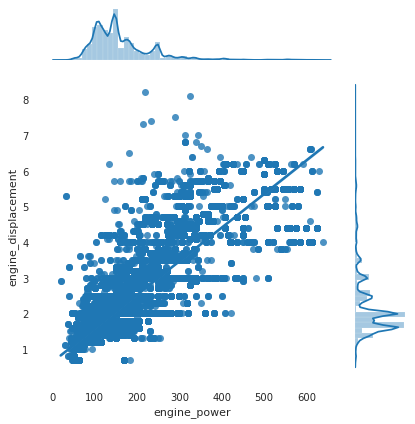

In [28]:
# Заменим неподходящие значения на единый стандарт
rename_item = {'Оригинал': 'ORIGINAL',
               'Дубликат': 'DUPLICATE',
               'автоматическая': 'AUTOMATIC',
               'механическая': 'MECHANICAL',
               'вариатор': 'VARIATOR',
               'роботизированная': 'ROBOT',
               'Левый': 'LEFT',
               'Правый': 'RIGHT',
               '040001': 'чёрный',
               'FAFBFB': 'белый',
               'CACECB': 'серебристый',
               '97948F': 'серый',
               '0000CC': 'синий',
               '200204': 'коричневый',
               'EE1D19': 'красный',
               '007F00': 'зеленый',
               'C49648': 'бежевый',
               '22A0F8': 'голубой',
               '660099': 'пурпурный',
               'DEA522': 'золотой',
               '4A2197': 'фиолетовый',
               'FFD600': 'желтый',
               'FF8649': 'оранжевый',
               'FFC0CB': 'розовый',
               }
# Проведем замену слов
for column in ['body_type', 'vehicle_transmission', 'color', 'licence', 'wheel']:
    df = df.replace({column: rename_item})  # заменим
    df[column] = df[column].apply(lambda x: None if pd.isnull(
        x) else x.lower())  # приведем все к нижнему регистру

# Оставим только первое число в переменных 'owners'и'engine_power' и переведем их в числовой формат
for column in ['owners', 'engine_power' ]:
    df[column] = df[column].astype(str).apply(lambda x: x.split()[0])
    df[column] = df[column].astype(float)

# Приведём признак engine_displacement к строковому типу и оставим только числовые данные.
df['engine_displacement'] = df['engine_displacement'].astype(str)
df['engine_displacement'] = df['engine_displacement'].str.extract(
    '(\d.\d)', expand=False).str.strip()
# Заменим все некорректные числа(объём двигателя в литрах) более 10 на None
df['engine_displacement'] = df['engine_displacement'].apply(
    lambda x: None if float(x) > 10 else x).astype(float)

sns.jointplot(x='engine_power', y='engine_displacement',
              data=df, kind='reg')

## Заполним пустые значения

body_type                    1
brand                        0
color                        0
complectation_dict       28268
description               3254
engine_displacement      21124
engine_power                 1
equipment_dict           99374
fuel_type                    0
mileage                      0
model_date                   1
model_name                   0
number_of_doors              1
production_date              0
vehicle_configuration        1
vehicle_transmission         1
owners                   13588
ownership                82868
licence                    362
type_of_drive                1
wheel                        0
price                      410
sample                       0
dtype: int64


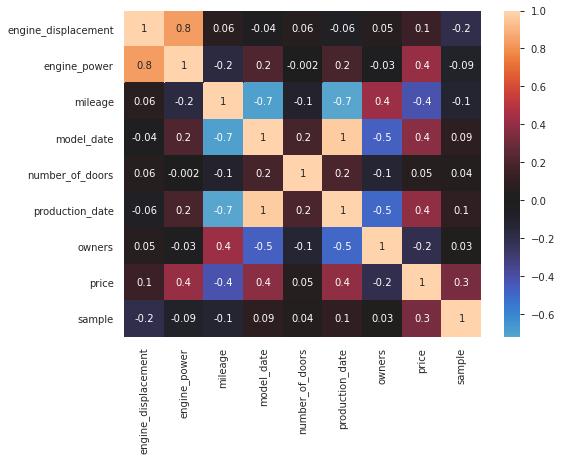

In [29]:
# посмотрим, где у нас пропуски и построим корреляционную матрицу для признаков

print(df.isna().sum())
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt='.1g', center=0, ax=ax)

In [30]:
# в признаке body_type есть данные с лишней информацией, приведем их к стандартному виду
df.body_type.value_counts()

внедорожник 5 дв.                  44113
седан                              43740
хэтчбек 5 дв.                      10792
лифтбек                             5353
универсал 5 дв.                     4661
                                   ...  
седан 120                              1
пикап полуторная кабина rap cab        1
пикап двойная кабина supercrew         1
хэтчбек 5 дв. runx                     1
седан lwb                              1
Name: body_type, Length: 168, dtype: int64

In [31]:
#удалим пропущенное значение
#f.dropna(subset=['body_type'], inplace=True)

# если убрать данные по количеству дверей, можно значительно уменьшить количество вариаций данного признака
df['body_type'] = df['body_type'].astype(str).apply(lambda x: None if x.strip()=='' else x)
df['body_type'] = df.body_type.apply(lambda x: x.split(' ')[0].lower())

In [32]:
# Учитывая хорошую корреляционную связь пробега и количество владельцев,
# можно посчитать среднее значение владельцев в зависимости от пробега.
# Отсюда можно выделить 3 переломных цифры,когда в среднем владелец меняется.
bins = np.arange(0, 170000, 10000)
df.groupby(pd.cut(df.mileage, bins)).owners.median()

mileage
(0, 10000]          1.0
(10000, 20000]      1.0
(20000, 30000]      1.0
(30000, 40000]      1.0
(40000, 50000]      1.0
(50000, 60000]      1.0
(60000, 70000]      2.0
(70000, 80000]      2.0
(80000, 90000]      2.0
(90000, 100000]     2.0
(100000, 110000]    2.0
(110000, 120000]    2.0
(120000, 130000]    2.0
(130000, 140000]    2.0
(140000, 150000]    3.0
(150000, 160000]    3.0
Name: owners, dtype: float64

In [33]:
change_owners = [0, 65000, 145000, 1e6]  # список км смены владельца
labels = [1, 2, 3]
df['mileage_owners'] = pd.cut(df['mileage'], bins=change_owners,
                              labels=labels, include_lowest=True)  # добавим вспомогательное поле
df['owners'] = df['owners'].fillna(
    df['mileage_owners'])  # заполним пропуски
df = df.drop('mileage_owners', axis=1)  # удалим вспомогательное поле

In [34]:
# Заменим модой пропуски в ПТС на "дубликат".
df['licence'] = df['licence'].fillna('duplicate')

# Заменим пропуски в description на "без описания"
df['description'] = df['description'].fillna('без описания')

In [35]:
# признаки, в которых было большое число пропусков придется удалить, поскольку они представляют собой словари с разнородной информацией,
# что затрудняет их представление в едином стандартном виде,хотя признак complectation_dict может довольно заметно влиять на целевую переменную, 
# в данном случае мы не можем использовать его для нашей модели
df.drop(['complectation_dict','equipment_dict', 'ownership'], axis=1, inplace=True)

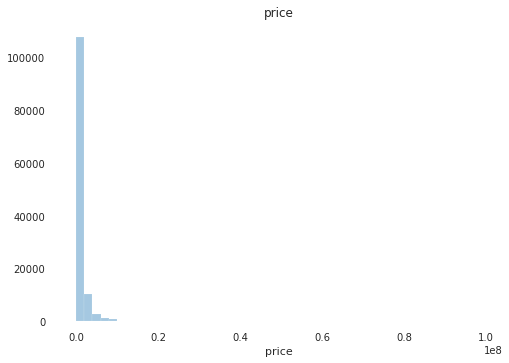

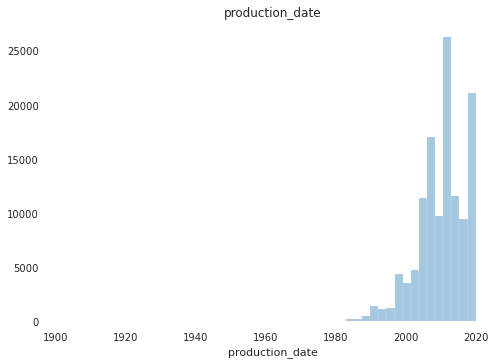

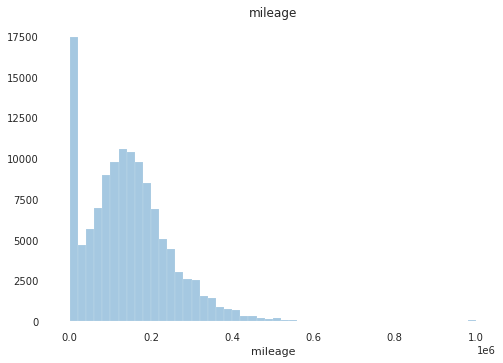

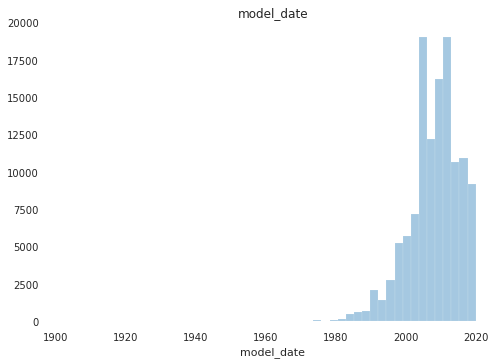

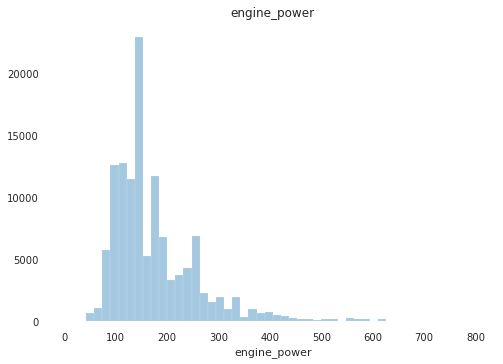

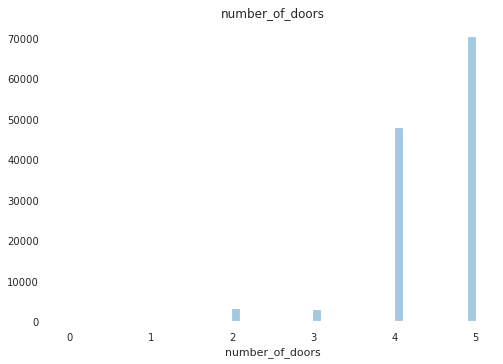

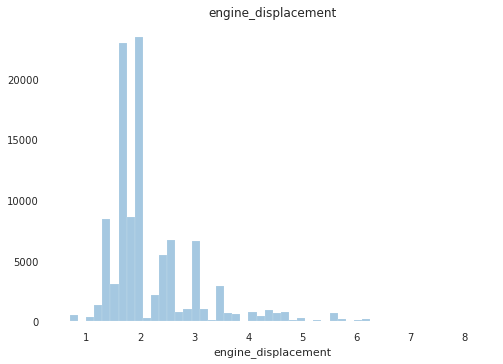

In [36]:
num_cols = ['price',
            'production_date',
            'mileage',
            'model_date',
            'engine_power',
            'number_of_doors',
            'engine_displacement']

for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Как видим, распределения признаков нормальные, но с тяжелым правым или левым хвостом, что может свидетельствовать о наличии выбросов в данных.


In [37]:
# в признаке number_of_doors - для некоторых авто количество дверей указано 0, что не может быть правдой
# заменим нулевые значения на моду данного признака, т.е. 5
df.number_of_doors = df.number_of_doors.apply(lambda x:x if x!=0 else 5)
df.number_of_doors = df.number_of_doors.fillna(4.0)

In [38]:
df.sample(5)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_name,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,owners,licence,type_of_drive,wheel,price,sample
85987,внедорожник,NISSAN,серый,"САЛОНЫ, АУКЦИОНЫ, ПЕРЕКУПЫ И ПРОЧАЯ НЕЧИСТЬ МИ...",2.5,169.0,бензин,227114,2007.0,X_TRAIL,5.0,2008,ALLROAD_5_DOORS VARIATOR 2.5,variator,3,original,полный,left,650000.0,1
89144,седан,OPEL,золотой,"на полном ходу, вложений не требует, масло не ...",2.5,170.0,бензин,250000,1995.0,VECTRA,4.0,1998,SEDAN MECHANICAL 2.5,mechanical,3,duplicate,передний,left,110000.0,1
56390,седан,FORD,серый,"ABS, бортовой компьютер, передние сиденья с по...",1.6,105.0,бензин,163000,2011.0,FOCUS,4.0,2012,SEDAN ROBOT 1.6,robot,2,original,передний,left,460000.0,1
54481,хэтчбек,FORD,красный,"Состояние хорошее сели и поехали,богатая компл...",1.6,125.0,бензин,50000,2014.0,FOCUS,5.0,2016,HATCHBACK_5_DOORS ROBOT 1.6,robot,3,original,передний,left,575000.0,1
2141,лифтбек,SKODA,белый,Новый экономичный автомобиль. Комплектация Ста...,1.6,90.0,бензин,7645,2017.0,RAPID,5.0,2018,LIFTBACK MECHANICAL 1.6,mechanical,1,original,передний,left,0.0,0


In [39]:
# заполним пропущенные значения в признаке engine_displacement значением моды данного признака, т.е 2.0
df.engine_displacement = df.engine_displacement.fillna(2.0)

## Feature Engineering

In [40]:
# Налоговым кодексом РФ установлены следующие ставки транспортного налога на одну лошадиную силу:
# до 100 л.с. — 2,5 рубля, от 100 до 150 л.с. включительно — 3,5 рубля, свыше 150 и до 200 л.с. включительно — 5 рублей,
# свыше 200 и до 250 л.с. включительно — 7,5 рублей и свыше 250 л.с. — 15 рублей.
# используя эту информацию, создадим новый признак tax_group

def set_tax(x):
    if x < 100:
        return 1
    elif 100 <= x <=150:
        return 2
    elif 150 < x <= 200:
        return 3
    elif 200 < x <= 250:
        return 4
    else:
        return 5

df['tax_group'] = df.engine_power.apply(lambda x:set_tax(x))


In [41]:
# создадим новый признак, отображающий средний годовой пробег авто - для этого разделим общий пробег на количество лет использования
df['year_mileage'] = round(df.mileage / (2020 - df.production_date))
#df['year_mileage'] = df.production_date / df.mileage
df['year_mileage']=df['year_mileage'].replace([-np.Inf,np.NINF,np.Inf], 0)
df['year_mileage'] = df['year_mileage'].fillna(0)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   body_type              124064 non-null  object  
 1   brand                  124064 non-null  object  
 2   color                  124064 non-null  object  
 3   description            124064 non-null  object  
 4   engine_displacement    124064 non-null  float64 
 5   engine_power           124063 non-null  float64 
 6   fuel_type              124064 non-null  object  
 7   mileage                124064 non-null  int64   
 8   model_date             124063 non-null  float64 
 9   model_name             124064 non-null  object  
 10  number_of_doors        124064 non-null  float64 
 11  production_date        124064 non-null  int64   
 12  vehicle_configuration  124063 non-null  object  
 13  vehicle_transmission   124063 non-null  object  
 14  owners              

In [43]:
df.sample(5)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_name,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,owners,licence,type_of_drive,wheel,price,sample,tax_group,year_mileage
76158,внедорожник,MAZDA,серебристый,Сборка Япония. Авто в отличном состоянии. Не т...,2.3,238.0,бензин,155000,2006.0,CX_7,5.0,2008,ALLROAD_5_DOORS AUTOMATIC 2.3,automatic,2,original,полный,left,500000.0,1,4,12917.0
74377,седан,MAZDA,чёрный,"Авто полностью в исправном состоянии, все что ...",1.6,105.0,бензин,220000,2011.0,3,4.0,2011,SEDAN AUTOMATIC 1.6,automatic,3,duplicate,передний,left,510000.0,1,2,24444.0
12861,внедорожник,NISSAN,серый,"Ксеноновые фары, 4 WD, ABS, блютус телефон, EB...",2.0,141.0,бензин,126000,2006.0,QASHQAI,5.0,2007,ALLROAD_5_DOORS VARIATOR 2.0,variator,2,original,полный,left,0.0,0,2,9692.0
113474,внедорожник,GREAT_WALL,серый,Автомобиль в хорошем состоянии. Комплект зимне...,2.0,122.0,бензин,195000,2010.0,HOVERH3,5.0,2010,ALLROAD_5_DOORS MECHANICAL 2.0,mechanical,2,original,полный,left,378000.0,1,2,19500.0
102610,седан,TOYOTA,белый,"Продаётся пушечка сотик, 1jz-ge на АКПП и на 1...",2.5,200.0,бензин,337538,1996.0,MARK_II,4.0,1997,SEDAN AUTOMATIC 2.5,automatic,3,duplicate,задний,right,350000.0,1,3,14676.0


In [44]:
# создадим признак, показывающий количество символов в описании
df['len_description'] = df.description.apply(lambda x:len(x))

# попробуем определить по описанию, является продавец частным лицом или компанией
dealer = 'официальный дилер|тест-драйв|автокредит|лот|выгода до|при обмене на ваш автомобиль|эксклюзивные предложения'
df['dealer'] = df.description.str.contains(dealer)*1

#удалим description
df.drop('description', inplace=True, axis=1)

In [45]:
# удалим строки с пропусками в целевой переменной
df.dropna(subset=['price'],inplace=True)

In [46]:
# заполним пропуски в признаке engine_power
df['engine_power'] = fill_na_values('engine_power',df)

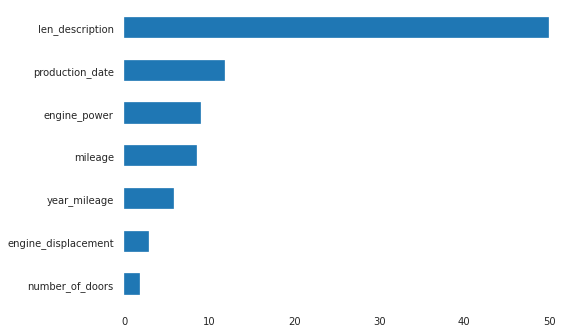

In [47]:
# посмотрим, как влияют на целевую переменную числовые признаки
num_cols = ['engine_displacement','engine_power','mileage','number_of_doors','production_date','year_mileage', 'len_description']

imp_num = pd.Series(f_classif(df[num_cols], df['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [48]:
# реализуем метод OneHotLabels для признаков fuel_type и type_of_drive
cols = ['fuel_type', 'type_of_drive']
df = pd.get_dummies(df, prefix=cols, columns=cols)
df.shape

(123654, 30)

## Label Encoding

In [49]:
df_new = df.copy() 

# Кодируем категориальные признаки
cat_cols = list(df.select_dtypes(exclude='number').columns)
for column in cat_cols:
    df_new[column] = df_new[column].astype('category').cat.codes

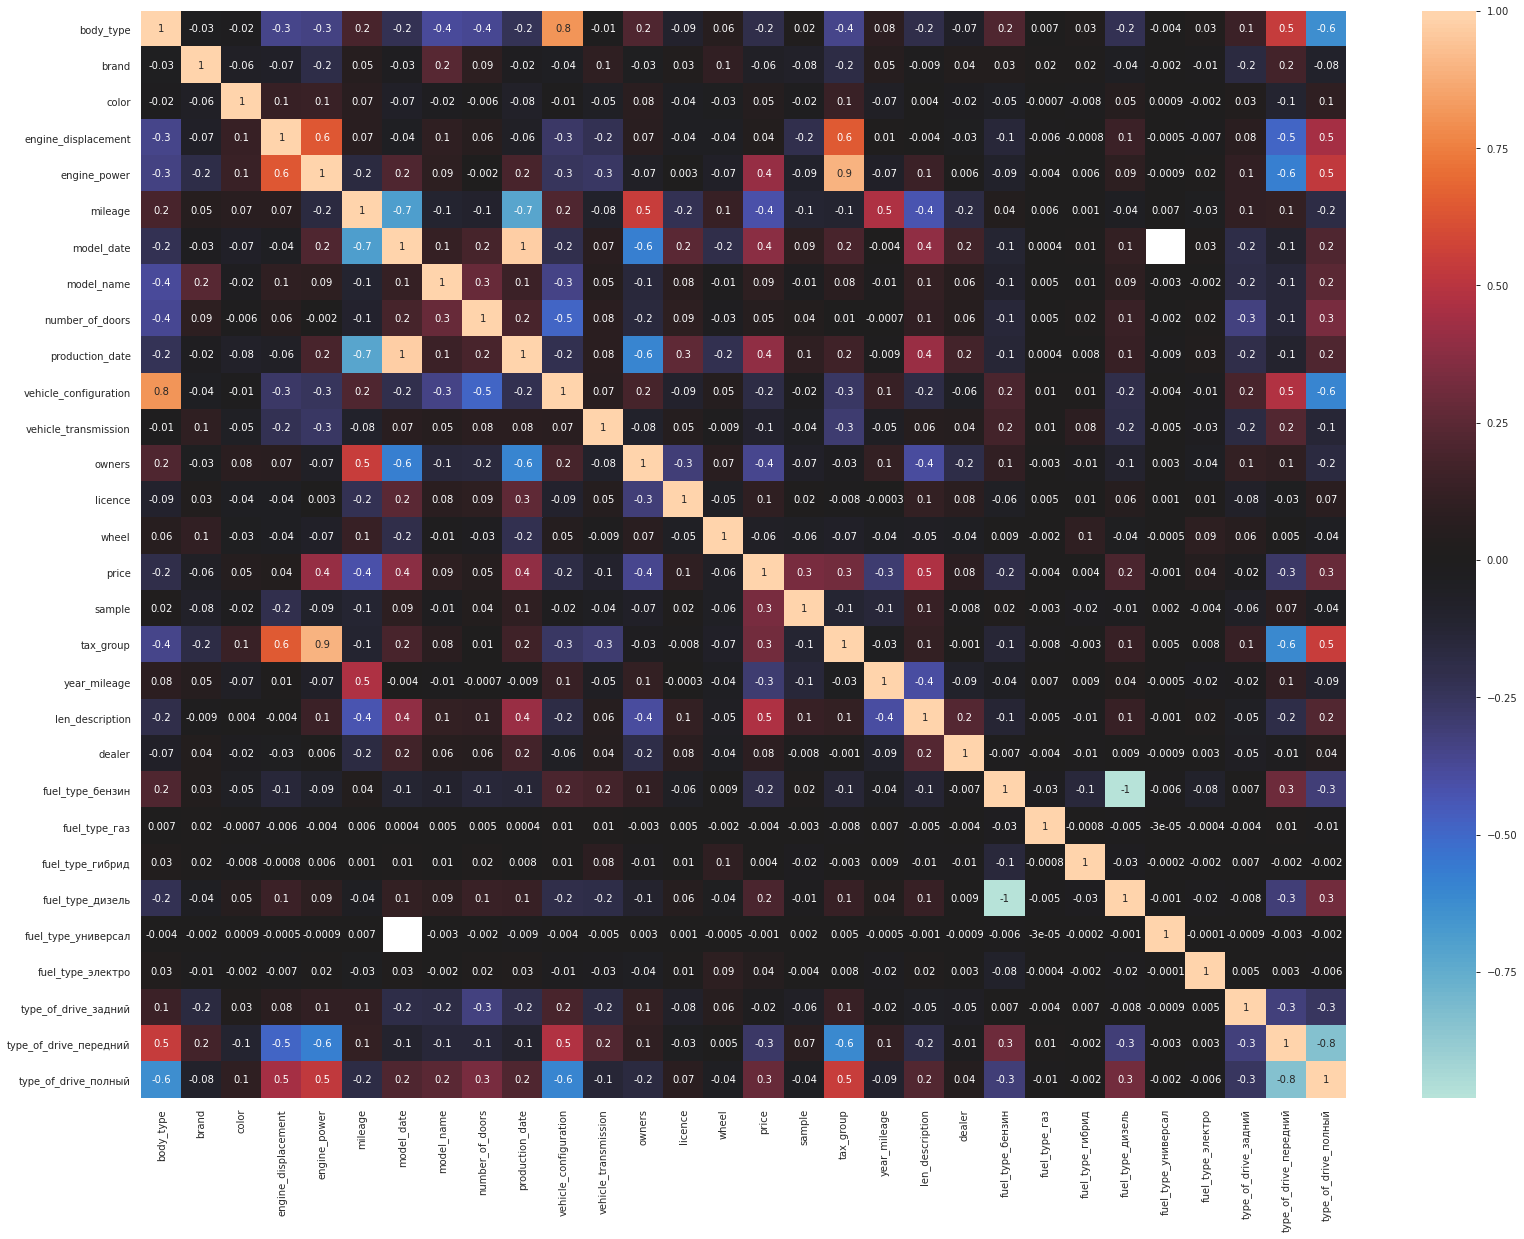

In [50]:
# посмотрим корреляционные связи между признаками
fig, ax = plt.subplots(figsize=(27, 20))
sns.heatmap(df_new.corr(),
            annot=True, fmt='.1g', center=0, ax=ax)

Видим высокую корреляцию между:
- production_date и model_date (1) - удалим model_date
- engine_displacement и engine_power (0,9) - удалим engine_displacement 
- body_type и vehicle_configuration (0,8)- удалим vehicle_configuration
- mileage и production_date (-0,7)
- mileage и model_date (-0,7)

In [51]:
df_new = df_new.drop(['model_date', 'engine_displacement',
                        'vehicle_configuration'], axis=1)

In [52]:
df_new.head()

,body_type,brand,color,engine_power,mileage,model_name,number_of_doors,production_date,vehicle_transmission,owners,licence,wheel,price,sample,tax_group,year_mileage,len_description,dealer,fuel_type_бензин,fuel_type_газ,fuel_type_гибрид,fuel_type_дизель,fuel_type_универсал,fuel_type_электро,type_of_drive_задний,type_of_drive_передний,type_of_drive_полный
0,7,29,16,105.0,74000,684,5.0,2014,2,2,1,0,0.0,0,2,12333.0,1001,1,1,0,0,0,0,0,0,1,0
1,7,29,18,110.0,60563,684,5.0,2017,1,0,1,0,0.0,0,2,20188.0,2609,1,1,0,0,0,0,0,0,1,0
2,7,29,15,152.0,88000,919,5.0,2014,2,0,1,0,0.0,0,3,14667.0,1001,1,1,0,0,0,0,0,0,1,0
3,7,29,9,110.0,95000,684,5.0,2014,0,0,1,0,0.0,0,2,15833.0,1676,1,1,0,0,0,0,0,0,1,0
4,7,29,1,152.0,58536,684,5.0,2012,0,0,1,0,0.0,0,3,7317.0,2365,1,1,0,0,0,0,0,0,1,0


Итак, датасет для обучения моделей готов. Он включает в себя следующие **признаки**:

- price - цена автомобиля (целевая переменная)

- body_type - тип кузова
- brand - марка автомобиля
- color - цвет автомобиля
- engine_power - мощность двигателя
- mileage - пробег
- model_name - модель автомобиля
- number_of_doors - количество дверей
- production_date - дата производства автомобиля
- vehicle_transmission - конфигурация трансмиссии транспортного средства
- owners - количество владельцев
- licence - паспорт ТС (оригинал или дубликат)
- wheel - расположение руля
- sample - индикатор принадлежности данных (test 0,train 1)
- tax_group - группа налогообложения в соответствии с Налоговым кодексом РФ
- year_mileage - средний пробег автомобиля в год (пробег, разделенный на количество лет эксплуатации)
- len_description - количество символов в описании автомобиля
- fuel_type - тип топлива
- type_of_drive - тип привода

# Machine learning

In [53]:
X = df_new.query('sample == 1').drop(['sample','price'], axis=1)
X_sub = df_new.query('sample == 0').drop(['sample','price'], axis=1)

y = df_new.query('sample == 1').price

## Train Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (mileage). 
C ней будем сравнивать другие модели.




In [55]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

predict = X_test['mileage'].map(tmp_train.groupby('mileage')['price'].median())

print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 73.45%


# Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Log Traget

In [56]:
#start_time = time.time()
# CatBoostLog = CatBoostRegressor(iterations=5000,
#                             random_seed=RANDOM_SEED,
#                             eval_metric='MAPE',
#                             custom_metric=['R2', 'MAE'],
#                             silent=True,
#                             )
#skf = StratifiedKFold(n_splits=4, random_state=RANDOM_SEED)
#cat_boost_mape_values = []

# for train_index, test_index in skf.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

#    CatBoostLog.fit(X_train, np.log(y_train),
#                  eval_set=(X_test, np.log(y_test)),
#                  verbose_eval=0,
#                  use_best_model=True)

#    y_pred = np.exp(CatBoostLog.predict(X_test))

#    cat_boost_mape_value = mape(y_test, y_pred)
#    cat_boost_mape_values.append(cat_boost_mape_value)
#    print(cat_boost_mape_value)

#score = round(np.mean(cat_boost_mape_values) * 100,2)
# print(
#    f"The MAPE mertic for the default CatBoost model using 4-fold CV is: {score}%.")

##program_time = time.time() - start_time
#output_submission(CatBoostLog, 'CatBoostLog_fold',score,program_time)

In [57]:
#start_time = time.time()
#CatBoost = CatBoostRegressor(iterations=5000,
#                             random_seed=RANDOM_SEED,
#                             eval_metric='MAPE',
#                             custom_metric=['R2', 'MAE'],
#                             silent=True,
#                             )

#CatBoost.fit(X_train, np.log(y_train),
#             eval_set=(X_test, np.log(y_test)),
#             verbose_eval=0,
#             use_best_model=True,)
#y_pred = np.exp(CatBoost.predict(X_test))
#score = round((mape(y_test, y_pred)) * 100, 2)
#print(
#    f"The MAPE mertic for the default CatBoost model is: {score}%.")

#program_time = time.time() - start_time
#output_submission(CatBoost, 'CatBoost_log', score,program_time)

### The MAPE mertic for the CatBoost_log model is: 12.57% with time 55.35583806037903. And on the leaderboard is: 13.42582%

# Model 3 : ExtraTreesRegressor


In [58]:
#start_time = time.time()
#etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

#skf = StratifiedKFold(n_splits=4, random_state=RANDOM_SEED)
#etr_log_mape_values = []

#for train_index, test_index in skf.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

#    etr_log.fit(X_train, np.log(y_train))

#    y_pred = np.exp(etr_log.predict(X_test))

#    etr_log_mape_value = mape(y_test, y_pred)
#    etr_log_mape_values.append(etr_log_mape_value)
#    print(etr_log_mape_value)

#score = round(np.mean(etr_log_mape_values) * 100, 2)
#print(
#    f"The MAPE mertic for the default ExtraTreesRegressor model using 4-fold CV is: {score}%.")

#program_time = time.time() - start_time
#output_submission(etr_log, 'ExtraTreesRegressor_fold', score, program_time)

In [59]:
start_time = time.time()
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

etr_log.fit(X_train, np.log(y_train))

y_pred = np.exp(etr_log.predict(X_test))
score = round(mape(y_test,y_pred) * 100,2) 

print(f"The MAPE mertic for the default ExtraTreesRegressor model is: {score}%.")

program_time = time.time() - start_time
output_submission(etr_log, 'ExtraTreesRegressor',score,program_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


The MAPE mertic for the default ExtraTreesRegressor model is: 13.4%.


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


ExtraTreesRegressor - sample submission


,sell_id,price
0,1100575026,5.490000e+05
1,1100549428,8.974776e+05
2,1100658222,8.518455e+05
3,1100937408,6.275791e+05
4,1101037972,7.051990e+05
5,1100912634,7.575371e+05
6,1101228730,5.852986e+05
7,1100165896,3.650000e+05
8,1100768262,1.536352e+06
9,1101218501,9.622560e+05


### The MAPE mertic for the ExtraTreesRegressor model is: 13.4% with time 13.048412561416626. And on the leaderboard is: 11.57359%

# Model 4 : XGBoostRegressor

In [60]:
#start_time = time.time()
# xgb_log = xgb.XGBRegressor(
#    objective='reg:squarederror',
#    colsample_bytree=0.5,
#    learning_rate=0.05,
#    max_depth=12,
#    alpha=1,
#    n_estimators=1000,
#    random_state=RANDOM_SEED,
#    n_jobs=-1,
# )

#skf = StratifiedKFold(n_splits=4, random_state=RANDOM_SEED)
#xgb_log_mape_values = []

# for train_index, test_index in skf.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[X.index.isin(
#        train_index)], X[X.index.isin(test_index)]
#    y_train, y_test = y[y.index.isin(
#        train_index)], y[y.index.isin(test_index)]

#    xgb_log.fit(X_train, np.log(y_train))

#    y_pred = np.exp(xgb_log.predict(X_test))

#    xgb_log_mape_value = mape(y_test, y_pred)
#    xgb_log_mape_values.append(xgb_log_mape_value)
#    print(xgb_log_mape_value)

#score = round(np.mean(xgb_log_mape_values) * 100,2)
# print(
#    f"The MAPE mertic for the XGBRegressor model using 4-fold CV is: {score}%.")

#program_time = time.time() - start_time
#output_submission(xgb_log, 'XGBRegressor_fold',score,program_time)

In [61]:
#start_time = time.time()
#xgb_log = xgb.XGBRegressor(
#    objective='reg:squarederror',
#    colsample_bytree=0.5,
#    learning_rate=0.05,
#    max_depth=12,
#    alpha=1,
#    n_estimators=1000,
#    random_state=RANDOM_SEED,
#    n_jobs=-1,
#)

#xgb_log.fit(X_train, np.log(y_train))

#y_pred = np.exp(xgb_log.predict(X_test))
#score = round(mape(y_test, y_pred) * 100, 2)
#print(
#    f"The MAPE mertic for the XGBRegressor model is: {score}%.")

#program_time = time.time() - start_time
#output_submission(xgb_log, 'XGBRegressor', score, program_time)

### The MAPE mertic for the XGBRegressor model is: 12.05% with time 146.7485637664795. And on the leaderboard is: 11.71639%

# Model 5 : RandomForestRegressor

In [62]:
#start_time = time.time()

#RFR = RandomForestRegressor(random_state=RANDOM_SEED, max_features=10,
#                            n_estimators=400, max_depth=18,
#                            min_samples_split=7)
#RFR.fit(X_train, np.log(y_train))
#y_pred = np.exp(RFR.predict(X_test))
#score = round(mape(y_test, y_pred) * 100, 2)

#print(f"The MAPE mertic for the Random Forest model is : {score}%.")

#program_time = time.time() - start_time
#output_submission(RFR, 'RandomForestRegressor', score, program_time)

### The MAPE mertic for the RandomForestRegressor model is: 13.07% with time 82.76050209999084. And on the leaderboard is: 13.65385%

# Model 6 : StackingRegressor

In [63]:
#start_time = time.time()
#estimators = [
#    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
#                             max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000, random_state=RANDOM_SEED))
#]

#sr_log = StackingRegressor(
#    estimators=estimators,
#    final_estimator=LinearRegression()
#)

#sr_log.fit(X_train, np.log(y_train))
#y_pred = np.exp(sr_log.predict(X_test))
#score = round(mape(y_test, y_pred) * 100, 2)

#print(
#    f"The MAPE mertic for the default StackingRegressor model: {score}%.")

#program_time = time.time() - start_time
#output_submission(sr_log, 'StackingRegressor', score, program_time)

### The MAPE mertic for the StackingRegressor model is: 12.7% with time 358.9000823497772

# Model 7 : Bagging

In [64]:
start_time = time.time()
bagging_model = BaggingRegressor(etr_log,  n_estimators = 25, max_samples = 0.6, 
                                 random_state=42).fit(X_train, np.log(y_train))

score = round(mape(y_test, y_pred) * 100, 2)
print(
    f"The MAPE mertic for the BaggingRegressor model is: {score}%.")

program_time = time.time() - start_time
output_submission(bagging_model, 'BaggingRegressor', score, program_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Don

The MAPE mertic for the BaggingRegressor model is: 13.4%.


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Paral

BaggingRegressor - sample submission


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


,sell_id,price
0,1100575026,5.829308e+05
1,1100549428,9.385687e+05
2,1100658222,8.494125e+05
3,1100937408,6.308831e+05
4,1101037972,7.648754e+05
5,1100912634,7.354483e+05
6,1101228730,6.231182e+05
7,1100165896,3.771315e+05
8,1100768262,1.584713e+06
9,1101218501,1.000693e+06


### The MAPE mertic for the BaggingRegressor model is: 13.4% with time 180.6331648826599

# Submission

In [65]:
for key, value in SUBMISSION_DICT.items():
    print(f'The MAPE mertic for the {key} model is: {value}')

The MAPE mertic for the ExtraTreesRegressor model is: 13.4% with time 12.710017681121826
The MAPE mertic for the BaggingRegressor model is: 13.4% with time 180.5779001712799


# ВЫВОДЫ

Таким образом, мы обучили и протестировали 7 моделей:

1. Наивная модель (МАРЕ - 
2. CatBoost Log Traget (MAPE - 13.42%, time 55.4)
3. ExtraTreesRegressor (MAPE - 11.72%, time 13.04)
4. XGBoostRegressor (MAPE - 12.05%, time 146.8)
5. RandomForestRegressor (MAPE - 13.65%, time 82.8)
6. StackingRegressor (MAPE - 12.7%, time 358.9)
7. BaggingRegressor (MAPE - 13.4%, time - 180.6)

Как видим, лучшей моделью стала модель на основе регрессии с экстра-деревьями. Она показала лучшее значение, как метрики МАРЕ, так и времени работы.
Таким образом, мы создали модель, предсказывающую стоимость автомобиля по его характеристикам, которая имеет MAPE 11.7%
